In [110]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [111]:
df = pd.read_csv('train.csv')

In [112]:
df

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
1,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,13 km/kg,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
2,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
3,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74
4,6,Nissan Micra Diesel XV,Jaipur,2013,86999,Diesel,Manual,First,23.08 kmpl,1461 CC,63.1 bhp,5.0,NaN,3.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5842,6014,Maruti Swift VDI,Delhi,2014,27365,Diesel,Manual,First,28.4 kmpl,1248 CC,74 bhp,5.0,7.88 Lakh,4.75
5843,6015,Hyundai Xcent 1.1 CRDi S,Jaipur,2015,100000,Diesel,Manual,First,24.4 kmpl,1120 CC,71 bhp,5.0,NaN,4.00
5844,6016,Mahindra Xylo D4 BSIV,Jaipur,2012,55000,Diesel,Manual,Second,14.0 kmpl,2498 CC,112 bhp,8.0,NaN,2.90
5845,6017,Maruti Wagon R VXI,Kolkata,2013,46000,Petrol,Manual,First,18.9 kmpl,998 CC,67.1 bhp,5.0,NaN,2.65


In [113]:
print(df.shape)

(5847, 14)


Number of Missing value in each column

In [114]:
missing_values_by_column = df.isnull().sum()
print("Missing Values Count by Column:")
print(missing_values_by_column)

Missing Values Count by Column:
Unnamed: 0              0
Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 36
Power                  36
Seats                  38
New_Price            5032
Price                   0
dtype: int64


In [29]:
total_rows = df.shape[0]
total_rows

5847

Percentage Of Missing value in each column

In [115]:
missing_percentages = (missing_values_by_column/ total_rows) * 100
print("missing_percentages:")
print(missing_percentages)

missing_percentages:
Unnamed: 0            0.000000
Name                  0.000000
Location              0.000000
Year                  0.000000
Kilometers_Driven     0.000000
Fuel_Type             0.000000
Transmission          0.000000
Owner_Type            0.000000
Mileage               0.034206
Engine                0.615700
Power                 0.615700
Seats                 0.649906
New_Price            86.061228
Price                 0.000000
dtype: float64


Clean and convert the data

In [116]:
def clean_and_convert(series, unit):

    series_cleaned = series.astype(str).str.replace(unit, '', regex=True).str.strip()
    series_cleaned = series_cleaned.replace('null', np.nan)
    return pd.to_numeric(series_cleaned, errors='coerce')


df['Mileage'] = clean_and_convert(df['Mileage'], r' kmpl| km/kg')
df['Engine'] = clean_and_convert(df['Engine'], r' CC')
df['Power'] = clean_and_convert(df['Power'], r' bhp')

In [117]:
def convert_new_price_to_lakh(price_series):

    prices = price_series.astype(str).str.strip().replace('null', np.nan)

    numeric_prices = prices.str.replace(r'[^\d\.]', '', regex=True)
    numeric_prices = pd.to_numeric(numeric_prices, errors='coerce')

    is_crore = prices.str.contains('Cr', na=False)

    numeric_prices[is_crore] *= 100

    return numeric_prices

df['New_Price_Lakh'] = convert_new_price_to_lakh(df['New_Price'])


print("Verification of New Price Conversion (Original vs. Converted Lakhs):")

print(df[df['New_Price_Lakh'].notna()][['New_Price', 'New_Price_Lakh']].head(10))

print(df[df['New_Price'].str.contains('Cr', na=False)][['New_Price', 'New_Price_Lakh']].head())

Verification of New Price Conversion (Original vs. Converted Lakhs):
     New_Price  New_Price_Lakh
1    8.61 Lakh            8.61
5      21 Lakh           21.00
8   10.65 Lakh           10.65
13  32.01 Lakh           32.01
18  47.87 Lakh           47.87
26  10.57 Lakh           10.57
32  12.33 Lakh           12.33
34  11.12 Lakh           11.12
42  23.64 Lakh           23.64
45  18.64 Lakh           18.64
     New_Price  New_Price_Lakh
140    1.28 Cr           128.0
314    1.04 Cr           104.0
469       1 Cr           100.0
1292   1.04 Cr           104.0
1457   1.39 Cr           139.0


Drop column New_price because it contains 86% of the missing value  

In [118]:
df.drop(columns=['New_Price'], inplace=True, errors='ignore')

Replace The missing value in column Engine, Power and Mileage by the median if the distribution is symmetric so median=mean if skwed the median is the most accurate

In [119]:
median_values = df.median(numeric_only=True)
df.fillna(median_values, inplace=True)

Replace the missing value in column seat by mode because it is a discret variable means we replace the missing by the most repeated value.



In [120]:
df['Seats'].fillna(df['Seats'].mode()[0], inplace=True)

/tmp/ipython-input-4194979564.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Seats'].fillna(df['Seats'].mode()[0], inplace=True)


In [121]:
df

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,Price,New_Price_Lakh
0,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,12.50,11.75
1,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,13.00,1199.0,88.70,5.0,4.50,8.61
2,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,6.00,11.75
3,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,17.74,11.75
4,6,Nissan Micra Diesel XV,Jaipur,2013,86999,Diesel,Manual,First,23.08,1461.0,63.10,5.0,3.50,11.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5842,6014,Maruti Swift VDI,Delhi,2014,27365,Diesel,Manual,First,28.40,1248.0,74.00,5.0,4.75,7.88
5843,6015,Hyundai Xcent 1.1 CRDi S,Jaipur,2015,100000,Diesel,Manual,First,24.40,1120.0,71.00,5.0,4.00,11.75
5844,6016,Mahindra Xylo D4 BSIV,Jaipur,2012,55000,Diesel,Manual,Second,14.00,2498.0,112.00,8.0,2.90,11.75
5845,6017,Maruti Wagon R VXI,Kolkata,2013,46000,Petrol,Manual,First,18.90,998.0,67.10,5.0,2.65,11.75


In [122]:
print(df.shape)

(5847, 14)


In [123]:
df.isnull().sum()

,0
Unnamed: 0,0
Name,0
Location,0
Year,0
Kilometers_Driven,0
Fuel_Type,0
Transmission,0
Owner_Type,0
Mileage,0
Engine,0


In [124]:
categorical_cols = ['Fuel_Type', 'Transmission']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=False)

bool_cols = [col for col in df_encoded.columns if col.startswith('Fuel_Type_') or col.startswith('Transmission_')]

for col in bool_cols:
    df_encoded[col] = df_encoded[col].astype(int)


print("New One-Hot Encoded Numerical Columns:")
print(df_encoded[[col for col in df_encoded.columns if col.startswith('Fuel_Type_') or col.startswith('Transmission_')]].dtypes)

df_encoded.to_csv('train_final_int_encoding.csv', index=False)

New One-Hot Encoded Numerical Columns:
Fuel_Type_Diesel          int64
Fuel_Type_Electric        int64
Fuel_Type_Petrol          int64
Transmission_Automatic    int64
Transmission_Manual       int64
dtype: object


In [125]:
df = pd.read_csv('train_final_int_encoding.csv')

In [126]:
df

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Owner_Type,Mileage,Engine,Power,Seats,Price,New_Price_Lakh,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual
0,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,First,19.67,1582.0,126.20,5.0,12.50,11.75,1,0,0,0,1
1,2,Honda Jazz V,Chennai,2011,46000,First,13.00,1199.0,88.70,5.0,4.50,8.61,0,0,1,0,1
2,3,Maruti Ertiga VDI,Chennai,2012,87000,First,20.77,1248.0,88.76,7.0,6.00,11.75,1,0,0,0,1
3,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Second,15.20,1968.0,140.80,5.0,17.74,11.75,1,0,0,1,0
4,6,Nissan Micra Diesel XV,Jaipur,2013,86999,First,23.08,1461.0,63.10,5.0,3.50,11.75,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5842,6014,Maruti Swift VDI,Delhi,2014,27365,First,28.40,1248.0,74.00,5.0,4.75,7.88,1,0,0,0,1
5843,6015,Hyundai Xcent 1.1 CRDi S,Jaipur,2015,100000,First,24.40,1120.0,71.00,5.0,4.00,11.75,1,0,0,0,1
5844,6016,Mahindra Xylo D4 BSIV,Jaipur,2012,55000,Second,14.00,2498.0,112.00,8.0,2.90,11.75,1,0,0,0,1
5845,6017,Maruti Wagon R VXI,Kolkata,2013,46000,First,18.90,998.0,67.10,5.0,2.65,11.75,0,0,1,0,1


In [127]:
df = pd.read_csv('train_final_int_encoding.csv')
current_year = 2025
df['Car_Age'] = current_year - df['Year']

df.to_csv('train_final_with_age.csv', index=False)
df = pd.read_csv('train_final_with_age.csv')

In [128]:
df

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Owner_Type,Mileage,Engine,Power,Seats,Price,New_Price_Lakh,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_Petrol,Transmission_Automatic,Transmission_Manual,Car_Age
0,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,First,19.67,1582.0,126.20,5.0,12.50,11.75,1,0,0,0,1,10
1,2,Honda Jazz V,Chennai,2011,46000,First,13.00,1199.0,88.70,5.0,4.50,8.61,0,0,1,0,1,14
2,3,Maruti Ertiga VDI,Chennai,2012,87000,First,20.77,1248.0,88.76,7.0,6.00,11.75,1,0,0,0,1,13
3,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Second,15.20,1968.0,140.80,5.0,17.74,11.75,1,0,0,1,0,12
4,6,Nissan Micra Diesel XV,Jaipur,2013,86999,First,23.08,1461.0,63.10,5.0,3.50,11.75,1,0,0,0,1,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5842,6014,Maruti Swift VDI,Delhi,2014,27365,First,28.40,1248.0,74.00,5.0,4.75,7.88,1,0,0,0,1,11
5843,6015,Hyundai Xcent 1.1 CRDi S,Jaipur,2015,100000,First,24.40,1120.0,71.00,5.0,4.00,11.75,1,0,0,0,1,10
5844,6016,Mahindra Xylo D4 BSIV,Jaipur,2012,55000,Second,14.00,2498.0,112.00,8.0,2.90,11.75,1,0,0,0,1,13
5845,6017,Maruti Wagon R VXI,Kolkata,2013,46000,First,18.90,998.0,67.10,5.0,2.65,11.75,0,0,1,0,1,12


In [129]:
import pandas as pd
import numpy as np


df = pd.read_csv('train_final_with_age.csv')


df_select = df[['Name', 'Location', 'Car_Age', 'Price']]
print("1. SELECT: First 3 rows of selected columns (Name, Location, Car_Age, Price)")
print(df_select.head(3))


df_filter = df[(df['Car_Age'] < 5) & (df['Price'] > 20)]
print("\n2. FILTER: Count of cars less than 5 years old and > 20 Lakhs")
print(f"Count: {len(df_filter)}")
print(df_filter[['Name', 'Car_Age', 'Price']].head(3))


df_rename = df.rename(columns={'Kilometers_Driven': 'Odometer_Reading'})
print("\n3. RENAME: Check if 'Kilometers_Driven' is now 'Odometer_Reading'")
print(df_rename.columns.tolist()[:8])


df['Power_to_Engine_Ratio'] = df['Power'] / df['Engine']
print("\n4. MUTATE: New 'Power_to_Engine_Ratio' feature added")
print(df[['Power', 'Engine', 'Power_to_Engine_Ratio']].head(3))


df_arrange = df.sort_values(by=['Price', 'Car_Age'], ascending=[False, True])
print("\n5. ARRANGE: Top 3 most expensive cars (sorted by Price desc, then Age asc)")
print(df_arrange[['Name', 'Price', 'Car_Age']].head(3))


df_summarize = df.groupby('Owner_Type').agg(
    Avg_Price=('Price', 'mean'),
    Max_Car_Age=('Car_Age', 'max'),
    Min_Car_Age=('Car_Age', 'min'),
    Total_Cars=('Owner_Type', 'count')
).reset_index()

print("\n6. SUMMARIZE with GROUP BY: Aggregated statistics by Owner Type")
print(df_summarize)

1. SELECT: First 3 rows of selected columns (Name, Location, Car_Age, Price)
                               Name Location  Car_Age  Price
0  Hyundai Creta 1.6 CRDi SX Option     Pune       10   12.5
1                      Honda Jazz V  Chennai       14    4.5
2                 Maruti Ertiga VDI  Chennai       13    6.0

2. FILTER: Count of cars less than 5 years old and > 20 Lakhs
Count: 0
Empty DataFrame
Columns: [Name, Car_Age, Price]
Index: []

3. RENAME: Check if 'Kilometers_Driven' is now 'Odometer_Reading'
['Unnamed: 0', 'Name', 'Location', 'Year', 'Odometer_Reading', 'Owner_Type', 'Mileage', 'Engine']

4. MUTATE: New 'Power_to_Engine_Ratio' feature added
    Power  Engine  Power_to_Engine_Ratio
0  126.20  1582.0               0.079772
1   88.70  1199.0               0.073978
2   88.76  1248.0               0.071122

5. ARRANGE: Top 3 most expensive cars (sorted by Price desc, then Age asc)
                                             Name  Price  Car_Age
3952  Land Rover Range R

Exercise2

In [130]:
seed_value = 42
sample_size = 25
percentile = 0.98
np.random.seed(seed_value)

df = pd.read_csv('diabetes.csv')


In [131]:
population_mean_glucose = df['Glucose'].mean()
population_max_glucose = df['Glucose'].max()

In [132]:
print(df.shape)

(768, 9)


In [133]:
print(population_mean_glucose)
print(population_max_glucose)

120.89453125
199


In [134]:
population_mean_glucose = df['Glucose'].mean()
population_max_glucose = df['Glucose'].max()
df_sample = df.sample(n=sample_size, random_state=seed_value)
sample_mean_glucose = df_sample['Glucose'].mean()
sample_max_glucose = df_sample['Glucose'].max()

In [135]:
df_sample

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
668,6,98,58,33,190,34.0,0.430,43,0
324,2,112,75,32,0,35.7,0.148,21,0
624,2,108,64,0,0,30.8,0.158,21,0
690,8,107,80,0,0,24.6,0.856,34,0
473,7,136,90,0,0,29.9,0.210,50,0
204,6,103,72,32,190,37.7,0.324,55,0
97,1,71,48,18,76,20.4,0.323,22,0
336,0,117,0,0,0,33.8,0.932,44,0
568,4,154,72,29,126,31.3,0.338,37,0
148,5,147,78,0,0,33.7,0.218,65,0


In [136]:
print(df_sample.shape)

(25, 9)


In [137]:
print(sample_mean_glucose)
print(sample_max_glucose)

116.64
183


In [138]:
comparison_data = {
    'Statistic': ['Mean Glucose', 'Max Glucose'],
    'Population': [population_mean_glucose, population_max_glucose],
    'Sample': [sample_mean_glucose, sample_max_glucose]
}
df_comparison = pd.DataFrame(comparison_data)
print(df_comparison)

      Statistic  Population  Sample
0  Mean Glucose  120.894531  116.64
1   Max Glucose  199.000000  183.00


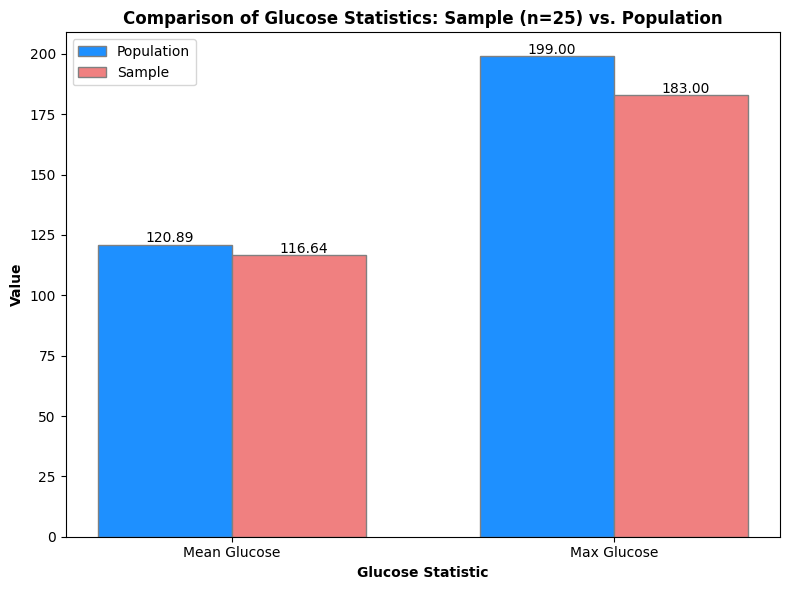

In [139]:
df_comparison = pd.DataFrame(comparison_data)

plt.figure(figsize=(8, 6))
bar_width = 0.35
r1 = np.arange(len(df_comparison['Statistic']))
r2 = [x + bar_width for x in r1]

plt.bar(r1, df_comparison['Population'], color='dodgerblue', width=bar_width, edgecolor='grey', label='Population')
plt.bar(r2, df_comparison['Sample'], color='lightcoral', width=bar_width, edgecolor='grey', label='Sample')

for i in range(len(r1)):
    plt.text(r1[i] - 0.05, df_comparison['Population'][i] + 1, f'{df_comparison["Population"][i]:.2f}', fontsize=10)
    plt.text(r2[i] - 0.05, df_comparison['Sample'][i] + 1, f'{df_comparison["Sample"][i]:.2f}', fontsize=10)

plt.xlabel('Glucose Statistic', fontweight='bold')
plt.ylabel('Value', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(df_comparison['Statistic']))], df_comparison['Statistic'])
plt.title('Comparison of Glucose Statistics: Sample (n=25) vs. Population', fontweight='bold')
plt.legend()
plt.tight_layout()
plt.savefig('glucose_comparison_chart_final.png')

In [140]:
population_98th_percentile_bmi = df['BMI'].quantile(0.98)
sample_98th_percentile_bmi = df_sample['BMI'].quantile(0.98)
print(f"Population 98th Percentile BMI: {population_98th_percentile_bmi:.2f}")
print(f"Sample 98th Percentile BMI: {sample_98th_percentile_bmi:.2f}")

Population 98th Percentile BMI: 47.53
Sample 98th Percentile BMI: 40.25


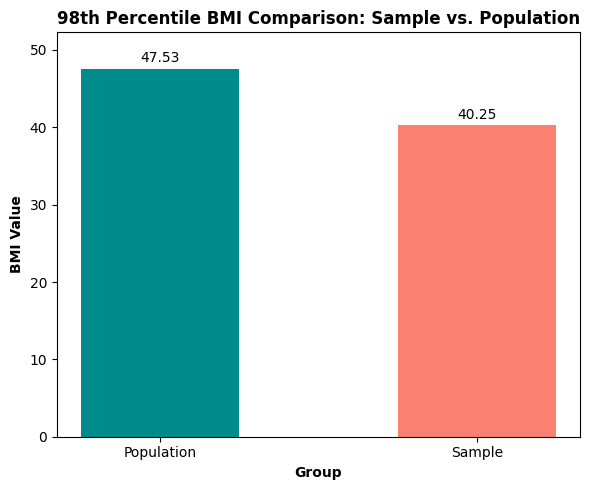

In [142]:
comparison_data = {
    'Group': ['Population', 'Sample'],
    'BMI_98th_Percentile': [population_98th_percentile_bmi, sample_98th_percentile_bmi]
}
df_comparison = pd.DataFrame(comparison_data)

plt.figure(figsize=(6, 5))
bars = plt.bar(df_comparison['Group'], df_comparison['BMI_98th_Percentile'],
               color=['darkcyan', 'salmon'], width=0.5)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5,
             f'{yval:.2f}', ha='center', va='bottom', fontsize=10)

plt.xlabel('Group', fontweight='bold')
plt.ylabel('BMI Value', fontweight='bold')
plt.title(f'98th Percentile BMI Comparison: Sample vs. Population', fontweight='bold')
plt.ylim(0, max(df_comparison['BMI_98th_Percentile']) * 1.1)
plt.tight_layout()
plt.savefig('bmi_98th_percentile_comparison_chart_final.png')

In [99]:
bp_pop = df['BloodPressure']
pop_mean = bp_pop.mean()
pop_std = bp_pop.std()
pop_25th = bp_pop.quantile(0.25)
pop_50th = bp_pop.quantile(0.50)
pop_75th = bp_pop.quantile(0.75)



In [ ]:
pop_stats_df = pd.DataFrame({
    'Statistic': ['Mean', 'Standard Deviation', '25th Percentile', '50th Percentile', '75th Percentile'],
    'Population': [pop_mean, pop_std, pop_25th, pop_50th, pop_75th]
})

In [100]:
n_bootstraps = 500
sample_size = 150

In [101]:
bootstrap_means = []
bootstrap_stds = []
bootstrap_25ths = []
bootstrap_50ths = []
bootstrap_75ths = []

In [103]:
for _ in range(n_bootstraps):

    sample = bp_pop.sample(n=sample_size, replace=True)


    bootstrap_means.append(sample.mean())
    bootstrap_stds.append(sample.std())
    bootstrap_25ths.append(sample.quantile(0.25))
    bootstrap_50ths.append(sample.quantile(0.50))
    bootstrap_75ths.append(sample.quantile(0.75))


boot_mean_avg = np.mean(bootstrap_means)
boot_std_avg = np.mean(bootstrap_stds)
boot_25th_avg = np.mean(bootstrap_25ths)
boot_50th_avg = np.mean(bootstrap_50ths)
boot_75th_avg = np.mean(bootstrap_75ths)


boot_stats_df = pd.DataFrame({
    'Statistic': ['Mean', 'Standard Deviation', '25th Percentile', '50th Percentile', '75th Percentile'],
    'Bootstrap Average': [boot_mean_avg, boot_std_avg, boot_25th_avg, boot_50th_avg, boot_75th_avg]
})


In [104]:
comparison_df = pd.merge(pop_stats_df, boot_stats_df, on='Statistic')

In [106]:
comparison_df

,Statistic,Population,Bootstrap Average
0,Mean,69.105469,69.155580
1,Standard Deviation,19.355807,19.175187
2,25th Percentile,62.000000,62.993000
3,50th Percentile,72.000000,71.553000
4,75th Percentile,80.000000,79.590000


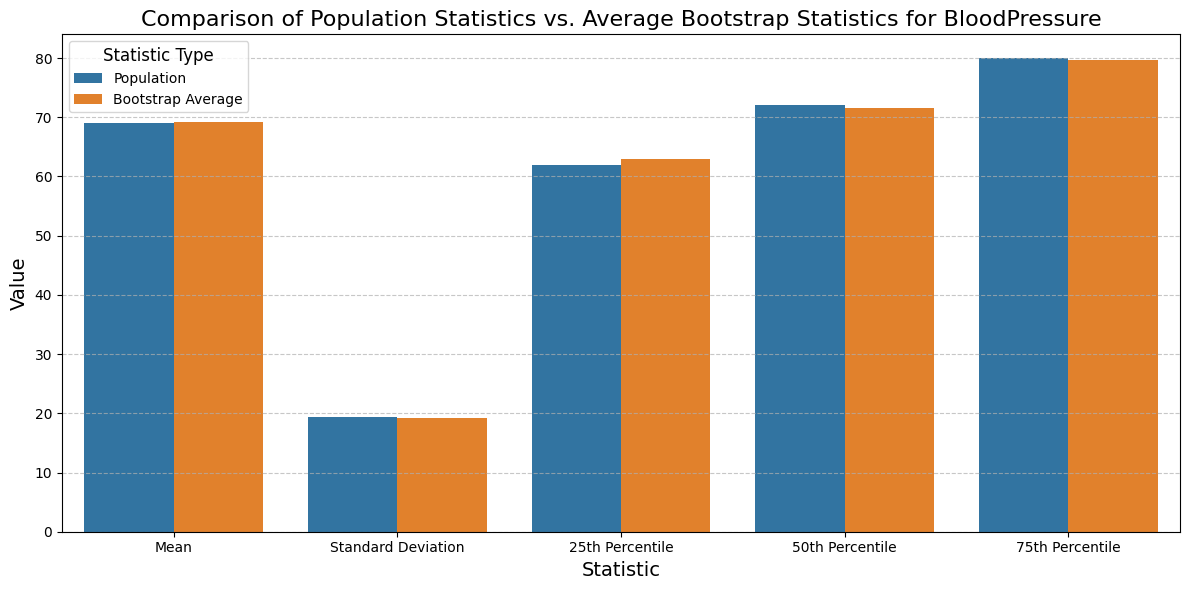

In [109]:
plot_df = pd.melt(comparison_df, id_vars='Statistic', var_name='Type', value_name='Value')


plt.figure(figsize=(12, 6))
sns.barplot(x='Statistic', y='Value', hue='Type', data=plot_df)
plt.title('Comparison of Population Statistics vs. Average Bootstrap Statistics for BloodPressure', fontsize=16)
plt.xlabel('Statistic', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.xticks(rotation=0)
plt.legend(title='Statistic Type', title_fontsize='12', fontsize='10')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()


plt.savefig('bloodpressure_bootstrap_comparison_bar_chart_final.png')
plt.show()

Report:

The average bootstrap mean 69.16 is extremely close to the population mean 69.11.

 The average bootstrap median 71.55 is very close to the population median 72.00.

 The average bootstrap 25th percentile and 75 percentile are also closer to the population  25th percentile and 75 percentile.


